# Bayesian Machine Learning : Naive Bayes Classifier

In [1]:
%load_ext lab_black

## The Iris dataset

We will work with the Ronald Fischer dataset, which dates from 1936 and contains data on irises.

We will see that the first 4 columns correspond respectively to the length of the sepal, the width of the sepal
the length of the petal and the width of the petal (all these measurements are in centimetres). These 4 variables will constitute the input. The fifth column corresponds to the species of the iris (which can be: Iris-Setosa, Iris-Versicolor or Iris-Virginica) and constitutes the output. It is therefore a classification problem: we want to build a predictor predicting the species according to the other characteristics.

### Question 1: Prepare the dataset

- Import the [Iris dataset](https://curiousml.github.io/teaching/epita-python/Iris.csv)
- Rename the column `Species` by `y`
- Replace the Species 
    - `Iris-setosa` by $0$, 
    - `Iris-versicolor` by $1$ and 
    - `Iris-virginica` by $2$
- Shuffle the dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

df = pd.read_csv("DataSet/Iris.csv")
df.drop(["Id"], axis=1, inplace=True)
df.rename(columns={"Species": "y"}, inplace=True)
df.y.replace(
    ["Iris-setosa", "Iris-versicolor", "Iris-virginica"], [0, 1, 2], inplace=True
)
df = shuffle(df, random_state=42).reset_index(drop=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


First, we want to simplify the dataset by reducing the dimension of the input space from 4 to 2. We then need to determine which two variables seem to be the most promising for predicting the species. To do this, we will use the sns.pairplot function from the Seaborn library.

```
import seaborn as sns
sns.pairplot(iris, hue="y")
```

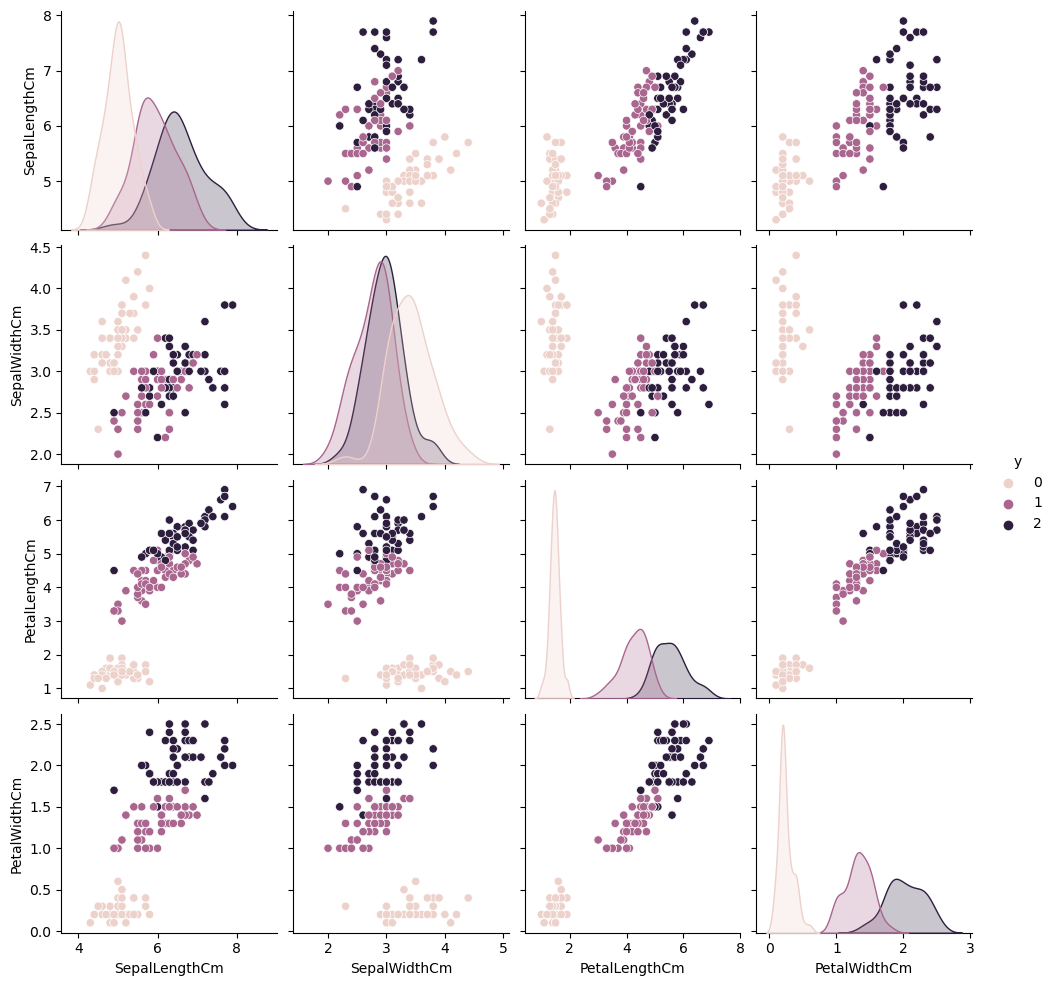

In [3]:
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.pairplot(df, hue="y")

* From the KDE graph, the PetalLengthCm and PetalWidthCm are the most two separated features
* From the scatter plot,  the correlation between PetalLengthCm and PetalWidthCm also shows the best distinguish border

**In conclusion, the best choice is ['PetalLengthCm', 'PetalWidthCm']**

### Question 2: simplify the dataset

Create an array `X` containing the columns corresponding to the two selected variables, as well as an array `y` containing the column corresponding to the species (`iris.values` can be used to return all the data from the iris DataFrame iris in the form of an NumPy array).

In [4]:
X = df[["PetalLengthCm", "PetalWidthCm"]]
y = df.y

### Question 3: split the dataset

Split the dataset into two samples: a training sample of size 90 (called `X_train` and `y_train`), and a test sample of size 60 (called `X_test` and `y_test`).

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=90, test_size=60, random_state=42
)

## Naive Bayes Classifier (from scratch)

Let us fit a [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), more particularily a **Gaussian Naive Bayes Classifier** where $P(X_i|Y)$ is a Gaussian probability distribution.

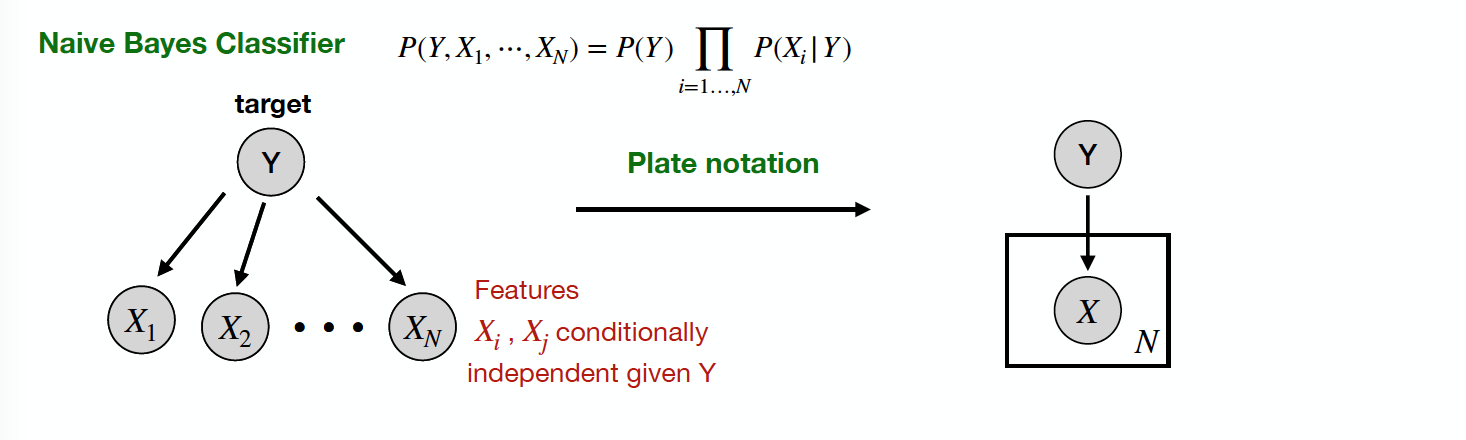

We are interested in the conditional probability of each input variable. This means we need:
1. one distribution for each of the input variables, and 
2. one set of distributions for each of the class labels.

As a first step let us model the input variables using a Gaussian probability distribution.

### Question 4: fit a gaussian probability distribution

Let us fit a Gaussian probability distribution to each feature. Create a function `fit_gaussian(feature)` which takes one input feature and fits a Gaussian probability distribution.

**Rmk:**
- you can use the `norm` function of `scipy.stats` for constructing a distribution;
- you can use the `mean` and the `std` function of `numpy` for estimating the parameters of the distribution

In [6]:
from scipy.stats import norm


def fit_gaussian(feature):
    mean = np.mean(feature)
    std = np.std(feature)
    dist = norm(mean, std)
    return dist

### Question 5: split the training set

Split the training set into groups of samples for each of the class labels $0, 1, 2$. Name them respectively `X_train0`, `X_train1` and `X_train2`. These groups are used to calculate the prior probabilities $P(Y)$ for a data sample belonging to each group.

In [7]:
# X and y are still in the same row, like 井
index0 = y_train == 0
index1 = y_train == 1
index2 = y_train == 2

X_train0 = X_train[index0]
X_train1 = X_train[index1]
X_train2 = X_train[index2]

X_train0.head()

,PetalLengthCm,PetalWidthCm
39,1.5,0.1
97,1.1,0.1
33,1.6,0.2
101,1.4,0.3
62,1.6,0.2


### Question 6: generate the priors $P(Y=y)$

Use `X_train0`, `X_train1` and `X_train2` to calculate the prior probabilities $P(Y=y)$ for $y\in\{0, 1, 2\}$. Name them respectively `prior0`, `prior1` and `prior2`

In [8]:
prior0 = len(X_train0) / len(X_train)
prior1 = len(X_train1) / len(X_train)
prior2 = len(X_train2) / len(X_train)



### Question 7: generate the PDFs $P(X_i|Y=y)$ 
Finally, we can call the `fit_gaussian` function that we defined to prepare a probability distribution for each variable, for each class label.
Generate the PDFs $P(X_i|Y=y)$ for $y\in\{0, 1, 2\}$.

In [9]:
features = X_train.shape[1]
pdf0 = [fit_gaussian(X_train0.iloc[:, i]) for i in range(features)]
pdf1 = [fit_gaussian(X_train1.iloc[:, i]) for i in range(features)]
pdf2 = [fit_gaussian(X_train2.iloc[:, i]) for i in range(features)]

### Question 8: generate the joint probabilities $P(Y=y, X_1, X_2)$


Create a function `joint_proba(X, prior, distX1, distX2)` which computes $P(Y, X_1, X_2)$ for a given class $Y=y$ (example $y=0$).
- `prior` corresponds to the prior probability $P(Y=y)$
- and `distXi`, $i=1, 2$, corresponds to $P(X_i|Y=y)$.

In [10]:
def joint_proba(X, prior, dists):
    probs = prior
    for i in range(X.shape[1]):
        probs *= dists[i].pdf(X.iloc[:, i])
    return probs

### Question 9: performance on the test set

- Compute the probabilities $P(Y=y, X_1, X_2)$ for $y\in\{0, 1, 2\}$.
- Evaluate the `Accuracy` of the model on the test set `X_test`

In [11]:
joint_probs0 = joint_proba(X_test, prior0, pdf0)
joint_probs1 = joint_proba(X_test, prior1, pdf1)
joint_probs2 = joint_proba(X_test, prior2, pdf2)

In [12]:
joint_probs0.shape

(60,)

In [13]:
m = np.stack((joint_probs0, joint_probs1, joint_probs2), axis=1)
y_pred = np.argmax(m, axis=1)
y_pred.shape

(60,)

In [14]:
y_test.shape

(60,)

In [15]:
accuracy = np.mean(y_pred == y_test)
accuracy

0.9833333333333333

## Naive Bayes Classifier (with external package)

### Question 10: GaussianNB of sklearn

- Create and train a Gaussian Classifier using `GaussianNB` of the external submodule `sklearn.naive_bayes`.
```
from sklearn.naive_bayes import GaussianNB
```


- Evaluate the `Accuracy` of the model on the test set `X_test`.

**Rm:** You should have (approximately) the same accuracy as in **Question 9**.

In [16]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.9833333333333333

## Some advantages

- Fast and accurate method for prediction.


- Naive Bayes has very low computation cost.


- It can efficiently work on a large dataset.


- It can be used in multi-class tasks.


- When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like logistic regression.

## Disadvantages

- The assumption of independent features. 

## Homework

**Show that:**

$$
\mathcal{N}(\theta \mid x/2, 1/2) = \frac{\mathcal{N}(x \mid \theta, 1) \times \mathcal{N}(\theta \mid 0, 1)}{P(x)}
$$

**Solution:**

Known:
$
\frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)
$
\begin{align*}
\mathcal{N}(\theta \mid 0, 1) &= \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{\theta^2}{2}\right) \\
\mathcal{N}(x \mid \theta, 1) &= \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - \theta)^2}{2}\right) \\
\mathcal{N}(x \mid \theta, 1) \times \mathcal{N}(\theta \mid 0, 1) &= \left(\frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - \theta)^2}{2}\right)\right) \times \left(\frac{1}{\sqrt{2\pi}} \exp\left(-\frac{\theta^2}{2}\right)\right) \\
&= \frac{1}{2\pi} \exp\left(-\frac{(x - \theta)^2 + \theta^2}{2}\right) \\
&= \frac{1}{2\pi} \exp\left(-\frac{x^2}{2} + x\theta - \theta^2\right) \\
P(x) 
&= \int_{-\infty}^{\infty} \mathcal{N}(x \mid \theta, 1) \mathcal{N}(\theta \mid 0, 1) \, d\theta \\
&= \int_{-\infty}^{\infty} \frac{1}{2\pi} \exp\left(-\frac{x^2}{2} + x\theta - \theta^2\right) d\theta \\
&=  \frac{\exp\left( -\frac{x^2}{4} \right)}{2 \sqrt{\pi}} \quad\quad  \text{according to wolframalpha} \\
\mathcal{N}(\theta \mid x/2, 1/2) 
&= \frac{1}{\frac{1}{2}\sqrt{2\pi}} \exp\left( -\frac{1}{2} \left( \frac{\frac{x}{2}}{\frac{1}{2}} \right)^2 \right)\\
&= \exp\left( -\frac{x^2}{2} \right) \sqrt{\frac{2}{\pi}} \Rightarrow\\
\\
\mathcal{N}(\theta \mid x/2, 1/2) &\neq \frac{\mathcal{N}(x \mid \theta, 1) \times \mathcal{N}(\theta \mid 0, 1)}{P(x)}
\end{align*}


